<a href="https://colab.research.google.com/github/maihuong1710/Applied-Data-Science-Capstone/blob/master/Capstone%20Project_Setting%20up%20a%20bookstore%20in%20Toronto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A used bookstore in Toronto**

### Business Problem:

Pearl Lee recently graduated from a university in Toronto, ON, Canada. During her student time, she realized that a lot of students cannot afford to buy new textbooks and the queue to borrow such textbooks from university library was always very long. As a student, she constantly thought of opening a used bookstore where students can buy textbooks at an affordable price. As soon as her graduation, she started to realise her idea: to open a used bookstore in Toronto. She teamed up with a data analyst team to find out where is the optimal place in Toronto to locate the bookstore.

### Data Description:

* List of Toronto boroughs and neighborhoods which can be found at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M to explore, segment, and cluster.
* Toronto's sociodemographic data which can be found at https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods.
* Information on venues in Toronto extracted from Foursquare.com

### Methodology

We will use K-mean clustering to segment and cluster Toronto neighborhoods to understand their similarity. With that understanding, we will be able to recommend a suitable place for Pearl Lee to set up her used bookstore. Such location would be near universities, in a populous but 'not too rich' neighborhoods.

**1. Import necessary libraries**

In [1]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
!conda install -c conda-forge geocoder --yes 
!pip install geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
Matplotlib version:  3.1.3
Libraries imported.


**2. Build Toronto dataframe**

In [2]:
# Read the Postcode table using pandas
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
# Ignore rows where 'Borough' is 'Not assigned' and then sort the table
df=df[~df.Borough.str.contains('Not assigned')]
df=df.sort_values(by=['Postcode','Borough','Neighbourhood'], ascending=[1,1,1]).reset_index(drop=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,Malvern
1,M1B,Scarborough,Rouge
2,M1C,Scarborough,Highland Creek
3,M1C,Scarborough,Port Union
4,M1C,Scarborough,Rouge Hill


In [0]:
# Assign 'Neighbourhood' the same name as 'Borough' if 'Neighbourhood' is 'Not assigned'
df.loc[df['Neighbourhood'] == 'Not assigned', ['Neighbourhood']] = df['Borough']

In [5]:
# Read Toronto's geographic coordination
lat_lon_df=pd.read_csv('http://cocl.us/Geospatial_data')
lat_lon_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Merge latitude and longitude of each postal code
df_postcode=pd.merge(df, lat_lon_df, how='left', left_on='Postcode', right_on='Postal Code').drop(['Postal Code'], axis=1)
df_postcode.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Malvern,43.806686,-79.194353
1,M1B,Scarborough,Rouge,43.806686,-79.194353
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497
3,M1C,Scarborough,Port Union,43.784535,-79.160497
4,M1C,Scarborough,Rouge Hill,43.784535,-79.160497


In [7]:
# Read the demographics table using pandas
raw_df1=pd.read_html("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")[1]
raw_df1.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [8]:
# Extract only necessary columns
df1 = raw_df1[['Name', 'Population', 'Density (people/km2)', 'Average Income', 'Second most common language (after English) by name']]
df1 = df1[df1['Name'] != 'Toronto CMA Average']
df1.rename(columns={'Name': 'Neighbourhood', 'Density (people/km2)': 'Density', 'Average Income': 'Income', 'Second most common language (after English) by name': '2nd language'}, inplace=True)
df1.head()

,Neighbourhood,Population,Density,Income,2nd language
1,Agincourt,44577,3580,25750,Cantonese (19.3%)
2,Alderwood,11656,2360,35239,Polish (6.2%)
3,Alexandra Park,4355,13609,19687,Cantonese (17.9%)
4,Allenby,2513,4333,245592,Russian (1.4%)
5,Amesbury,17318,4934,27546,Spanish (6.1%)


In [0]:
# Merge geographic and demographic information
df1=pd.merge(df1, df_postcode, how='inner', on='Neighbourhood')

In [10]:
df1.head()

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude
0,Agincourt,44577,3580,25750,Cantonese (19.3%),M1S,Scarborough,43.794200,-79.262029
1,Alderwood,11656,2360,35239,Polish (6.2%),M8W,Etobicoke,43.602414,-79.543484
2,Bathurst Manor,14945,3187,34169,Russian (9.5%),M3H,North York,43.754328,-79.442259
3,Bayview Village,12280,2966,46752,Cantonese (8.4%),M2K,North York,43.786947,-79.385975
4,Bedford Park,13749,6057,80827,Greek (0.7%),M5M,North York,43.733283,-79.419750


In [11]:
df1.shape

(80, 9)

**3. Discover Toronto**

In [12]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto Ontario are 43.653963, -79.387207.


In [13]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  

map_to

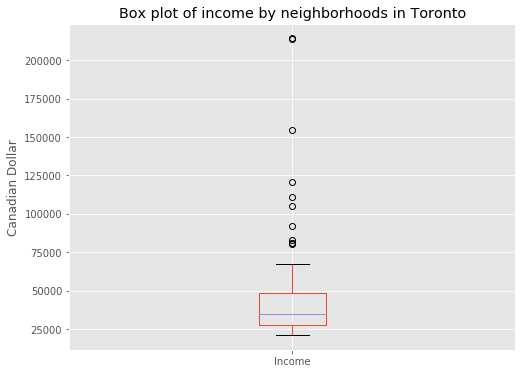

In [14]:
# Toronto income by neighborhoods
df1[['Income']].plot(kind='box', figsize=(8, 6))

plt.title('Box plot of income by neighborhoods in Toronto')
plt.ylabel('Canadian Dollar')

plt.show()

In [15]:
df1[['Income']].describe()

,Income
count,80.000000
mean,47151.425000
std,36281.688042
min,21155.000000
25%,27399.500000
50%,34997.000000
75%,48329.000000
max,214110.000000


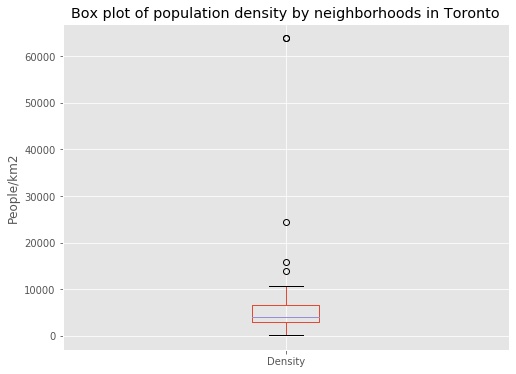

In [16]:
# Toronto population density by neighborhood
df1[['Density']].plot(kind='box', figsize=(8, 6))

plt.title('Box plot of population density by neighborhoods in Toronto')
plt.ylabel('People/km2')

plt.show()

In [17]:
df1[['Density']].describe()

,Density
count,80.000000
mean,6679.112500
std,9902.481244
min,198.000000
25%,2964.750000
50%,4061.500000
75%,6601.500000
max,63765.000000


**4. Use Foursquare API to explore Toronto venues**

In [18]:
# Foursquare Credentials
CLIENT_ID = '5O0023CQHWGGJE2XQ05DII0K0LFSYIA025NU1DWJLGYNI21L' # your Foursquare ID
CLIENT_SECRET = 'CETAGR4BTVOFM3QPTINFYGIVVYJE45QNUGQ3VLVNQKZRW1SP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 5O0023CQHWGGJE2XQ05DII0K0LFSYIA025NU1DWJLGYNI21L
CLIENT_SECRET:CETAGR4BTVOFM3QPTINFYGIVVYJE45QNUGQ3VLVNQKZRW1SP


In [19]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude
0,Agincourt,44577,3580,25750,Cantonese (19.3%),M1S,Scarborough,43.7942,-79.262029


In [20]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.7942003, -79.26202940000002.


In [21]:
# explore the top 100 venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5O0023CQHWGGJE2XQ05DII0K0LFSYIA025NU1DWJLGYNI21L&client_secret=CETAGR4BTVOFM3QPTINFYGIVVYJE45QNUGQ3VLVNQKZRW1SP&v=20180605&ll=43.7942003,-79.26202940000002&radius=2500&limit=100'

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e58cd501d67cb001bc73920'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c5c9bee94fd0f47cb30c945-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d144941735',
         'name': 'Caribbean Restaurant',
         'pluralName': 'Caribbean Restaurants',
         'primary': True,
         'shortName': 'Caribbean'}],
       'id': '4c5c9bee94fd0f47cb30c945',
       'location': {'address': '351 Pitfield Rd',
        'cc': 'CA',
        'city': 'Scarborough',
        'country': 'Canada',
        'crossStreet': 'McCowan Rd',
        'distance': 815,
        'formattedAddress': ['351 Pitfield Rd (McCowan Rd)',
         'Scarborough ON',
         'Canada'],
        'lab

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Roti Hut,Caribbean Restaurant,43.787277,-79.258724
1,Mona's Roti,Caribbean Restaurant,43.791613,-79.251015
2,Babu Catering & Take Out,Sri Lankan Restaurant,43.791721,-79.251132
3,Strength-N-U,Gym / Fitness Center,43.784888,-79.251685
4,Panagio's Breakfast & Lunch,Breakfast Spot,43.792370,-79.260203


In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Agincourt
Alderwood
Bathurst Manor
Bayview Village
Bedford Park
Birch Cliff
Brockton
Cabbagetown
Church and Wellesley
Clairlea
Cliffcrest
Cliffside
Davisville
Deer Park
Dorset Park
Downsview
Eringate
Flemingdon Park
Garden District
Grange Park
Guildwood
Henry Farm
Highland Creek
Humber Bay Shores
Humber Summit
Humberlea
Ionview
Kensington Market
Kingsview Village
Lawrence Heights
Lawrence Manor
Lawrence Park
Leaside
Little Portugal
Long Branch
Malvern
Markland Wood
Maryvale
Milliken
Moore Park
Morningside
Mount Dennis
New Toronto
Newtonbrook
Oakridge
Parkdale
Parkwoods
Port Union
Princess Gardens
Riverdale
Roncesvalles
Rosedale
Rouge
Rouge Hill
Runnymede
Runnymede
Scarborough Village
Silverthorn
South Hill
St. James Town
St. James Town
Sunnylea
Swansea
The Annex
The Beaches
The Kingsway
Thistletown
Thorncliffe Park
Toronto Islands
Victoria Village
West Deane Park
West Hill
Westmount
Weston
Wexford
Willowdale
Wilson Heights
Woburn
York Mills
Yorkville
(1429, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
1,Agincourt,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
2,Agincourt,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
3,Agincourt,43.794200,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
4,Agincourt,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
5,Alderwood,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
6,Alderwood,43.602414,-79.543484,Toronto Gymnastics International,43.599832,-79.542924,Gym
7,Alderwood,43.602414,-79.543484,Timothy's Pub,43.600165,-79.544699,Pub
8,Alderwood,43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop
9,Alderwood,43.602414,-79.543484,Pizza Pizza,43.605340,-79.547252,Pizza Place


In [28]:

# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
Alderwood,9,9,9,9,9,9
Bathurst Manor,20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
Bedford Park,24,24,24,24,24,24
Birch Cliff,4,4,4,4,4,4
Brockton,22,22,22,22,22,22
Cabbagetown,48,48,48,48,48,48
Church and Wellesley,84,84,84,84,84,84


In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 217 uniques categories.


In [30]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,History Museum,Hockey Arena,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Office,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
toronto_onehot.shape

(1429, 218)

In [32]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,History Museum,Hockey Arena,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Office,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.200000,0.0,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.2,0.0,0.0,0.000000,0.2,0.0,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.00,0.0,0.

In [33]:
toronto_grouped.shape

(74, 218)

In [0]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [0]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,History Museum,Hockey Arena,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Office,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.200000,0.0,0.0,0.0,0.0,0.

In [37]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Yoga Studio,Eastern European Restaurant,Filipino Restaurant
1,Alderwood,Pizza Place,Skating Rink,Pharmacy,Pub,Coffee Shop,Sandwich Place,Pool,Gym
2,Bathurst Manor,Coffee Shop,Frozen Yogurt Shop,Gas Station,Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Fried Chicken Joint
3,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Yoga Studio,Eastern European Restaurant,Fish & Chips Shop,Filipino Restaurant
4,Bedford Park,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Café,Juice Bar,Sushi Restaurant,Pub
5,Birch Cliff,Skating Rink,Café,College Stadium,General Entertainment,Yoga Studio,Donut Shop,Fast Food Restaurant,Farmers Market
6,Brockton,Café,Breakfast Spot,Coffee Shop,Intersection,Burrito Place,Pet Store,Climbing Gym,Stadium
7,Cabbagetown,Restaurant,Coffee Shop,Park,Bakery,Pub,Café,Italian Restaurant,Pizza Place
8,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Burger Joint,Gastropub,Mediterranean Restaurant
9,Clairlea,Bus Line,Soccer Field,Bus Station,Park,Metro Station,Intersection,Ice Cream Shop,Bakery


**5. Cluster**

In [0]:
import geopy.distance

In [0]:
# get coordinates of 4 universities in Toronto
location_UofT = geolocator.geocode('University of Toronto, ON')
latitude_UofT = 43.662954
longitude_UofT = -79.395968
location_YorkU = geolocator.geocode('York University, ON')
latitude_YorkU = 43.776234
longitude_YorkU = -79.502569
location_RyersonU = geolocator.geocode('Ryerson University, ON')
latitude_RyersonU = 43.657612
longitude_RyersonU = -79.378845
location_OCAD = geolocator.geocode('OCAD University, ON')
latitude_OCAD = 43.653428
longitude_OCAD = -79.391195

In [0]:
# calculate distance from each neighborhood to each university
Distance_UofT = df1.apply(lambda row: geopy.distance.vincenty((latitude_UofT, longitude_UofT), (row.Latitude, row.Longitude)).km, axis=1)
df1['Distance to University of Toronto'] = Distance_UofT.values

Distance_YorkU = df1.apply(lambda row: geopy.distance.vincenty((latitude_YorkU, longitude_YorkU), (row.Latitude, row.Longitude)).km, axis=1)
df1['Distance to York University'] = Distance_YorkU.values

Distance_RyersonU = df1.apply(lambda row: geopy.distance.vincenty((latitude_RyersonU, longitude_RyersonU), (row.Latitude, row.Longitude)).km, axis=1)
df1['Distance to Ryerson University'] = Distance_RyersonU.values

Distance_OCAD = df1.apply(lambda row: geopy.distance.vincenty((latitude_OCAD, longitude_OCAD), (row.Latitude, row.Longitude)).km, axis=1)
df1['Distance to OCAD University'] = Distance_OCAD.values

# calculate weighted average distance to each universities by relative size of universities
df1['Weighted average distance to universities'] = df1['Distance to University of Toronto']*0.45 + df1['Distance to York University']*0.35 + df1['Distance to Ryerson University']*0.15 + df1['Distance to OCAD University']*0.05

In [41]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = df1.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Postcode', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Borough', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Latitude', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Longitude', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Distance to University of Toronto', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Distance to York University', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Distance to Ryerson University', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Distance to OCAD University', 1)

toronto_grouped_clustering.head(10)

,Population,Density,Income,Weighted average distance to universities
0,44577,3580,25750,18.594261
1,11656,2360,35239,15.882081
2,14945,3187,34169,9.150514
3,12280,2966,46752,12.420620
4,13749,6057,80827,8.303983
5,12266,3525,48965,14.485463
6,9039,8217,27260,8.430696
7,11120,7943,50398,7.075248
8,13397,24358,37653,6.166043
9,11104,3102,33392,13.334967


In [42]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 4, 4, 2, 4, 4, 4, 4, 4], dtype=int32)

In [43]:
toronto_merged = toronto_data

# add clustering labels
df1['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = df1.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,44577,3580,25750,Cantonese (19.3%),M1S,Scarborough,43.794200,-79.262029,18.141201,19.464850,17.857781,18.787124,18.594261,0,Breakfast Spot,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Yoga Studio,Eastern European Restaurant,Filipino Restaurant
1,Alderwood,11656,2360,35239,Polish (6.2%),M8W,Etobicoke,43.602414,-79.543484,13.673314,19.592206,14.633927,13.534564,15.882081,4,Pizza Place,Skating Rink,Pharmacy,Pub,Coffee Shop,Sandwich Place,Pool,Gym
2,Bathurst Manor,14945,3187,34169,Russian (9.5%),M3H,North York,43.754328,-79.442259,10.816145,5.432025,11.899474,11.942386,9.150514,4,Coffee Shop,Frozen Yogurt Shop,Gas Station,Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Fried Chicken Joint
3,Bayview Village,12280,2966,46752,Cantonese (8.4%),M2K,North York,43.786947,-79.385975,13.800018,9.460976,14.381515,14.840862,12.420620,4,Café,Chinese Restaurant,Bank,Japanese Restaurant,Yoga Studio,Eastern European Restaurant,Fish & Chips Shop,Filipino Restaurant
4,Bedford Park,13749,6057,80827,Greek (0.7%),M5M,North York,43.733283,-79.419750,8.045677,8.201343,9.031021,9.166114,8.303983,2,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Café,Juice Bar,Sushi Restaurant,Pub


In [44]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].sort_values('Weighted average distance to universities', ascending=True).head(5)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
49,Riverdale,31007,7771,40139,Cantonese (6.7%),M4K,East Toronto,43.679557,-79.352188,3.983613,16.192221,3.250710,4.280856,8.161552,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Bookstore,Ice Cream Shop,Yoga Studio
41,Mount Dennis,21284,6469,23910,Spanish (7.3%),M6M,York,43.691116,-79.476013,7.173241,9.696206,8.675231,8.020181,8.323924,0,Fast Food Restaurant,Restaurant,Discount Store,Sandwich Place,Yoga Studio,Doner Restaurant,Farmers Market,Falafel Restaurant
45,Parkdale,28367,13974,26314,Polish (2.9%),M6R,West Toronto,43.648960,-79.456325,5.111129,14.623894,6.323943,5.277737,8.630849,0,Breakfast Spot,Gift Shop,Cuban Restaurant,Bank,Movie Theater,Coffee Shop,Bookstore,Restaurant
15,Downsview,36613,2270,26751,Italian (11.7%),M6L,North York,43.713756,-79.490074,9.456544,7.014322,10.924320,10.415954,8.869903,0,Construction & Landscaping,Park,Bakery,Basketball Court,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant
17,Flemingdon Park,21287,8760,23471,Urdu (6.3%),M3C,North York,43.725900,-79.340923,8.282700,14.169436,8.180000,9.014602,10.364248,0,Coffee Shop,Beer Store,Gym,Asian Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant


In [46]:
print('The number of neighborhoods in this cluster is', toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].shape[0])

The number of neighborhoods in this cluster is 14


In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].sort_values('Weighted average distance to universities', ascending=True).head(5)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
51,Rosedale,7672,2821,213941,Unspecified Chinese (1.0%),M4W,Downtown Toronto,43.679563,-79.377529,2.369903,14.726337,2.441145,3.105851,6.742139,1,Park,Playground,Trail,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
39,Moore Park,4474,3959,154825,French (1.1%),M4T,Central Toronto,43.689574,-79.383160,3.132830,13.610892,3.568207,4.068008,6.912217,1,Tennis Court,Trail,Yoga Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
31,Lawrence Park,6653,1828,214110,French (0.8%),M4N,Central Toronto,43.728020,-79.388790,7.252419,10.614571,7.863803,8.289957,8.572757,1,Bus Line,Gym / Fitness Center,Park,Swim School,Yoga Studio,Donut Shop,Fast Food Restaurant,Farmers Market


In [48]:
print('The number of neighborhoods in this cluster is', toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].shape[0])

The number of neighborhoods in this cluster is 3


In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].sort_values('Weighted average distance to universities', ascending=True).head(5)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
63,The Annex,15602,10614,63636,Spanish (1.3%),M5R,Central Toronto,43.672710,-79.405678,1.337243,13.901536,2.738225,2.440122,6.000037,2,Sandwich Place,Café,Park,Coffee Shop,Cosmetics Shop,Burger Joint,History Museum,Indian Restaurant
79,Yorkville,6045,10795,105239,French (1.9%),M5R,Central Toronto,43.672710,-79.405678,1.337243,13.901536,2.738225,2.440122,6.000037,2,Sandwich Place,Café,Park,Coffee Shop,Cosmetics Shop,Burger Joint,History Museum,Indian Restaurant
13,Deer Park,15165,10387,80704,Russian (1.1%),M4V,Central Toronto,43.686412,-79.400049,2.627054,12.954531,3.628159,3.733671,6.447168,2,Coffee Shop,Pub,Restaurant,Light Rail Station,Fried Chicken Joint,Supermarket,Sports Bar,Sushi Restaurant
58,South Hill,6218,4935,120453,French (1.0%),M4V,Central Toronto,43.686412,-79.400049,2.627054,12.954531,3.628159,3.733671,6.447168,2,Coffee Shop,Pub,Restaurant,Light Rail Station,Fried Chicken Joint,Supermarket,Sports Bar,Sushi Restaurant
4,Bedford Park,13749,6057,80827,Greek (0.7%),M5M,North York,43.733283,-79.419750,8.045677,8.201343,9.031021,9.166114,8.303983,2,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Café,Juice Bar,Sushi Restaurant,Pub


In [50]:
print('The number of neighborhoods in this cluster is', toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].shape[0])

The number of neighborhoods in this cluster is 10


In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3].sort_values('Weighted average distance to universities', ascending=True).head(5)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
59,St. James Town,14666,63765,22341,Filipino (8.1%),M4X,Downtown Toronto,43.667967,-79.367675,2.34895,16.212696,1.461279,2.491697,7.075248,3,Coffee Shop,Café,Restaurant,Italian Restaurant,Bakery,Park,American Restaurant,Clothing Store
60,St. James Town,14666,63765,22341,Filipino (8.1%),M5C,Downtown Toronto,43.651494,-79.375418,2.09027,17.236276,0.733825,1.290797,7.147932,3,Coffee Shop,Café,Restaurant,Italian Restaurant,Bakery,Park,American Restaurant,Clothing Store


In [52]:
print('The number of neighborhoods in this cluster is', toronto_merged.loc[toronto_merged['Cluster Labels'] == 3].shape[0])

The number of neighborhoods in this cluster is 2


In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4].sort_values('Weighted average distance to universities', ascending=True).head(5)

,Neighbourhood,Population,Density,Income,2nd language,Postcode,Borough,Latitude,Longitude,Distance to University of Toronto,Distance to York University,Distance to Ryerson University,Distance to OCAD University,Weighted average distance to universities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
8,Church and Wellesley,13397,24358,37653,Spanish (1.8%),M4Y,Downtown Toronto,43.665860,-79.383160,1.082338,15.587613,0.980255,1.525760,6.166043,4,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Burger Joint,Gastropub,Mediterranean Restaurant
27,Kensington Market,3740,10389,23335,Cantonese (14.3%),M5T,Downtown Toronto,43.653206,-79.400049,1.132020,15.972149,1.779208,0.714719,6.402278,4,Bar,Café,Vietnamese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Vegetarian / Vegan Restaurant
19,Grange Park,9007,10793,35277,Unspecified Chinese (14.8%),M5T,Downtown Toronto,43.653206,-79.400049,1.132020,15.972149,1.779208,0.714719,6.402278,4,Bar,Café,Vietnamese Restaurant,Bakery,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Vegetarian / Vegan Restaurant
18,Garden District,8240,15846,37614,Unspecified Chinese (3.0%),M5B,Downtown Toronto,43.657162,-79.378937,1.517025,16.561667,0.050568,1.072329,6.540446,4,Clothing Store,Coffee Shop,Bubble Tea Shop,Café,Japanese Restaurant,Bakery,Lingerie Store,Burger Joint
7,Cabbagetown,11120,7943,50398,Unspecified Chinese (1.6%),M4X,Downtown Toronto,43.667967,-79.367675,2.348950,16.212696,1.461279,2.491697,7.075248,4,Restaurant,Coffee Shop,Park,Bakery,Pub,Café,Italian Restaurant,Pizza Place


In [54]:
print('The number of neighborhoods in this cluster is', toronto_merged.loc[toronto_merged['Cluster Labels'] == 4].shape[0])

The number of neighborhoods in this cluster is 51


**6. Location recommendation**

Per the above result, the neighborhoods in cluster 4 seem to have highest similarity. It is also the most populous cluster, thus offer Pearl Lee a good chance to expanse her business in the future.

Due to the nature of business (used book bookstore), we would like to recommend Pearl Lee a location where the population density is high, but the average income should be medium or low. The bookstore should also be easily reachable from universities. With that in mind, it is apparent that Kenshington Market is the ideal choice for Pearl Lee to set up her bookstore. It is also noted that the second popular language spoken in Kenshington Market is Cantonese, and it adjacent neighborhood - Grange Park has very similar characteristics and is common with Chinese language, thus Pearl Lee may consider to offer books in that Cantonese and Chinese beside used student textbooks.